In [ ]:
########now part 2: decode and train#######

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/noa_raindel/.TF_cpu_new/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18349553426490273256
]


In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
from tensorflow.contrib.layers.python.layers import utils
#from preprocess_func_new import *
from matplotlib.image import imread
import os
from os.path import expanduser
# from tensorflow.python import keras
# from tensorflow.keras.applications.mobileNet import DepthwiseConv2D

%matplotlib inline

#tf.enable_eager_execution()

#tf.logging.set_verbosity(tf.logging.INFO)

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
img_path = os.path.join('..','datasets','stixels')
img_path

'../datasets/stixels'

In [5]:
percent=2 

In [6]:
tfrec_batch_size=1 #for path name only

In [7]:
batch_size=64

In [8]:
tfrec_train_directory = os.path.join('..','datasets','stixels','train','tfrec_batch_size_'
                                     +str(tfrec_batch_size)+'_precent_'+str(percent))
#### note there is a misspelling "precent"
tfrec_train_directory


'../datasets/stixels/train/tfrec_batch_size_1_precent_2'

In [9]:
#creating a list of paths to train tfrecs:
# path_tfrecords_train_lst=[]
# path_tfrecords_train = os.path.join(img_path, 'train')
# for root, dirs, files in os.walk(tfrec_train_directory):
#     for file in files:
#         if '.tfrecord' in file:
#             path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
#         else:
#             print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

#creating a list of paths to train tfrecs:
path_tfrecords_train_lst=[]
path_tfrecords_train = os.path.join(img_path, 'train')
for root, dirs, files in os.walk(tfrec_train_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')


In [10]:
len(path_tfrecords_train_lst)

398578

In [10]:
#shortening the list for experiments
path_tfrecords_train_lst = path_tfrecords_train_lst[:128]
##################

In [11]:
#params
H=370 
W=24
C=3
img_shape = (H, W, C)
num_classes = 47

In [12]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    #######image = tf.decode_raw(image_raw, tf.int32) ####
    image = tf.image.decode_png(image_raw, channels=3, dtype=tf.uint8) 
    #image = tf.cast(image, tf.int32)

    # The type is now uint8 but we need it to be float.
    
    image = tf.cast(image, tf.float32) ####
    
    # Get the label associated with the image.
    label = parsed_example['label']
    
    
    # The image and label are now correct TensorFlow types.
    return image, label

In [14]:
def input_fn(filenames, train, batch_size=batch_size, buffer_size=100000): 
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        ######dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    #dataset = dataset.batch(batch_size)
    #dataset = tf.contrib.data.batch_and_drop_remainder(batch_size)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    print('@@@')
    print(dataset.output_shapes)  # ==> "(16,)" (the batch dimension is known)
    print('@@@')
    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch
    return x, y

In [15]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst, train=True)

In [16]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_training = True
    else:
        is_training = False
    
    # Reference to the tensor named "image" in the input-function.
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1,H,W,C])

    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=(3,3),
                           activation=None, strides=(2,2),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    ###
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None,kernel_size=(3,3), stride=(1, 1),
                               activation_fn=None, depth_multiplier=1,
                               weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               padding='SAME'
                              )
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    net = tf.layers.conv2d(inputs=net, name='point_wize3',
                           filters=32, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    ####
    
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    net = tf.layers.conv2d(inputs=net, name='point_wize5',
                           filters=64, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    ####

    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(1,1),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                                    )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)  
    
    net = tf.layers.conv2d(inputs=net, name='point_wize7',
                           filters=128, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    ####
    
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)    
    
    net = tf.layers.conv2d(inputs=net, name='point_wize9',
                           filters=128, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    ####

    net = tf.contrib.layers.separable_conv2d(inputs=net,num_outputs=None, kernel_size=(3,3), stride=(1,1),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )

    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)  
    
    net = tf.layers.conv2d(inputs=net, name='point_wize11',
                           filters=256, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)    
    
    net = tf.layers.conv2d(inputs=net, name='point_wize13',
                           filters=256, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    for i in range(5):
        net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(1,1),
                                    activation_fn=None, depth_multiplier=1,
                                    weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                    padding='SAME'
                                   )

        net = tf.layers.batch_normalization(inputs=net, training=is_training)

        net = tf.nn.relu6(features=net)  
        
        net = tf.layers.conv2d(inputs=net, name='point_wize'+str(i+14),
                           filters=512, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
        net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
        net = tf.nn.relu6(features=net)
    
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net) 
    
    net = tf.layers.conv2d(inputs=net, name='point_wize19',
                           filters=512, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)    
    
    net = tf.layers.conv2d(inputs=net, name='point_wize20',
                           filters=1024, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net, training=is_training)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    net = tf.layers.average_pooling2d(inputs=net, pool_size=(6,1), strides=(1,1), name='layer_pool21')
    
    # Flatten to a 2-rank tensor.
    #net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    net = tf.layers.flatten(net)


    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc22',
                          units=47,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
        #######################
        lr = 1e-4
        step_rate = 5000
        decay = 0.7 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        

        
        # Define the optimizer for improving the neural network.
        #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        

#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
        
#         with tf.Session() as sess:
#             print('Learning rate: %f' % (sess.run(optimizer._learning_rate)))
        
    return spec

In [17]:
params = {} #{"learning_rate": 1e-5}

In [18]:
def make_dir_and_comment(model_dir):
    home = expanduser("~")
    log_name=os.path.join('logs/', model_dir + '.txt')
    
    if os.path.isdir(model_dir):
        print('INFO: dir with name ' + model_dir + ' already exist.')
    
    new_comment=input('Please add a comment\n')
    
    if os.path.exists(log_name):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    
    model_log = open(log_name,append_write)
    model_log.write(home +' : '+ new_comment + '\n')
    model_log.close()
    return



In [19]:
model_dir = 'ckpts_02_06_mobilenetV1_47bins_1e_minus4_tr1' #'./ckpts_<day>_<month>_<architecture>_<main_change>'
make_dir_and_comment(model_dir) 
# model = tf.estimator.Estimator(model_fn=model_fn,
#                                params=params,
#                                model_dir=model_dir)

model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir=model_dir,
                               config=tf.estimator.RunConfig().replace(save_checkpoints_steps=1000,save_summary_steps=10)
                              )

Please add a comment
.
INFO:tensorflow:Using config: {'_service': None, '_master': '', '_evaluation_master': '', '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'ckpts_02_06_mobilenetV1_47bins_1e_minus4_tr1', '_global_id_in_cluster': 0, '_is_chief': True, '_save_summary_steps': 10, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_session_config': None, '_save_checkpoints_secs': None, '_save_checkpoints_steps': 1000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe26b5c9160>, '_task_id': 0, '_tf_random_seed': None, '_task_type': 'worker'}


In [ ]:
model.train(input_fn=train_input_fn, steps=20000)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ckpts_02_06_mobilenetV1_47bins_1e_minus4_tr1/model.ckpt.
INFO:tensorflow:loss = 4.0825934, step = 1


In [ ]:
###DONE TRAIN###

In [37]:
#performance on training dataset:
def train_partial_input_fn():
#     return input_fn(path_tfrecords_train_lst[7000:8500], train=False) 
    return input_fn(path_tfrecords_train_lst[:500], train=False) 

train_partial_result = model.evaluate(input_fn=train_partial_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-10:57:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_02_06_mobilenetV1_47bins_swap_5e_minus4_fixed/model.ckpt-43001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-10:57:09
INFO:tensorflow:Saving dict for global step 43001: accuracy = 0.0625, global_step = 43001, loss = 3.6534457


In [ ]:
#VAL:

In [38]:
tfrec_val_batch_size=1

In [39]:
tfrec_val_directory = os.path.join('..','datasets','stixels','val','tfrec_batch_size_'+str(tfrec_val_batch_size))#+'_percent_'+str(percent))

In [40]:
path_tfrecords_val_lst=[]
path_tfrecords_val = os.path.join(img_path, 'val')
for root, dirs, files in os.walk(tfrec_val_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_val_lst.append(os.path.join(tfrec_val_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [41]:
len(path_tfrecords_val_lst)

127163

In [42]:
def val_input_fn():
    return input_fn(path_tfrecords_val_lst, train=False) 

In [43]:
val_result = model.evaluate(input_fn=val_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-10:58:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_02_06_mobilenetV1_47bins_swap_5e_minus4_fixed/model.ckpt-43001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-11:35:49
INFO:tensorflow:Saving dict for global step 43001: accuracy = 0.046080377, global_step = 43001, loss = 3.6840265


In [44]:
val_result

{'accuracy': 0.046080377, 'global_step': 43001, 'loss': 3.6840265}

In [45]:
print("Classification val accuracy: {0:.2%}".format(val_result["accuracy"]))

Classification val accuracy: 4.61%


In [46]:
# count variables in model
# np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

total_parameters = 0
for variable in model.get_variable_names():
    shape = model.get_variable_value(variable).shape
    variable_parameters = 1
    for dim in range(len(list(shape))):
        variable_parameters *= shape[dim]
    total_parameters += variable_parameters
print(total_parameters)

2221584


In [ ]:
#TEST:

In [38]:
tfrec_test_batch_size=1

In [163]:
tfrec_test_directory = os.path.join('..','datasets','stixels','test','tfrec_batch_size_'+str(tfrec_test_batch_size))

In [164]:
path_tfrecords_test_lst=[]
path_tfrecords_test = os.path.join(img_path, 'test')
for root, dirs, files in os.walk(tfrec_test_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_test_lst.append(os.path.join(tfrec_test_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [167]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test_lst[1000:2500], train=False)

In [221]:
test_result = model.evaluate(input_fn=test_input_fn)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-28-15:58:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-28-15:58:25
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.18953805, global_step = 20000, loss = 2.6755853


In [109]:
print("Classification test accuracy: {0:.2%}".format(test_result["accuracy"]))

Classification test accuracy: 11.55%


In [ ]:
#PRED:

In [53]:
sum_csv_test_path = os.path.join(img_path,'val', 'sum_csv') #TEST
labels_test=pd.read_csv(os.path.join(sum_csv_test_path,'labels_val_'+str(percent)+'percent.csv'))
test_names_list=list(labels_test['Name'])
image_paths_test=[]
for name in test_names_list:
    image_paths_test.append(os.path.join(img_path, 'val', name+'.png')) 


In [54]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    images = np.asarray(images)
    images=images*255 # Convert to a numpy array 
    return images


In [64]:
##TODO:SHUFFLE!
some_num=500
some_images = load_images(image_paths=image_paths_test[:some_num])
print(some_images.shape)
some_images_cls = np.array(labels_test['Label'][:some_num])
 

(500, 370, 24, 3)


In [66]:
some_images_cls[:224]

array([12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10,
       10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10])

In [67]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [77]:
predictions_np = model.predict(input_fn=predict_input_fn) 

In [78]:
cls_pred_np = np.array(list(predictions_np))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [80]:
cls_pred_np.shape

(500, 17)

In [84]:
cls_pred_2=np.argmax(cls_pred_np,axis=1)

In [88]:
cls_pred_2[:224]

array([ 9, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 10, 10, 10, 10,
       10, 10,  8,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  5,  5,  5,
        5,  5,  5,  5,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  4,  5,  5,  5,  5,  5,  5,  5,  6,
        8,  6,  6,  6,  6,  6,  6,  6,  6,  7, 11, 10, 11, 10, 10, 10, 10,
       10, 11, 11, 11, 10, 11, 12, 11, 10, 11, 11, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10,  9, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  5,  5,  5,  5,  6,  5,  6,  5,  5,
        5,  5,  5,  5,  4,  4,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 10,  9, 10, 10, 10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10,
        9,  9, 10,  9,  9,  9,  9,  9,  9, 11,  9,  8,  8,  9,  7, 11, 10,
       10, 10, 10, 10,  9,  7, 10, 10, 10,  9,  9,  8,  7,  7,  7,  9,  9,
       10, 10, 10])

In [90]:
cls_pred_2[:224]-some_images_cls[:224]

array([-3,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -2, -2, -2, -2, -2, -2, -3, -3, -2,
        0, -2, -2, -2, -2, -2, -2, -3, -3, -3,  1,  0,  1,  0, -1, -1, -1,
       -1,  0,  0,  0, -2, -1, -4,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  6,  6,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,
       -1,  0,  0,  0,  0,  0,  0,  1,  0, -1, -1, -1,  0, -1,  0, -1, -1,
       -1, -1, -1, -1, -2, -2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1, -1,  0,  0,  0,  0,  0,  1,  1,  0,  1,  1,  1,  1,  1,
        0,  0,  1,  0,  0,  0,  0,  0,  1,  3,  1,  0,  0,  1, -1,  3,  2,
        2,  2,  2,  2,  1, -2,  1,  1,  1,  0,  0, -1, -2, -2, -3, -1, -1,
        0,  0,  0])

In [106]:
import matplotlib.pyplot as plt
from skimage.transform import resize
def plot_im(img,cls):
    img = resize(img, (370,img.shape[1]))
    imgplot = plt.imshow(img)
    img[140+cls*15:140+(cls+1)*15,:,0]=1
    img[140+cls*15:140+(cls+1)*15,:,1:]=0
    #imgplot = plt.imshow(img)
    #plt.axis('off')
    #plt.show()
    return img[:,:5,:]
    

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


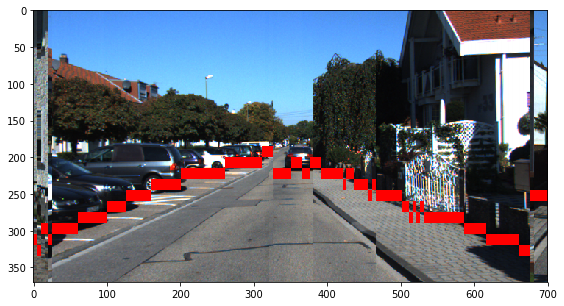

In [129]:
#plotting our preds:
some_images_for_plt = some_images[:]/255.0
img = np.ones([370, 1, 3])
for im in range(cls_pred_2[:].shape[0]):
    img0 = plot_im(some_images_for_plt[im,:,:,:], cls_pred_2[im])
    img=np.concatenate([img,img0],axis=1)
imgplot = plt.imshow(img[:,1250:1950,:])
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


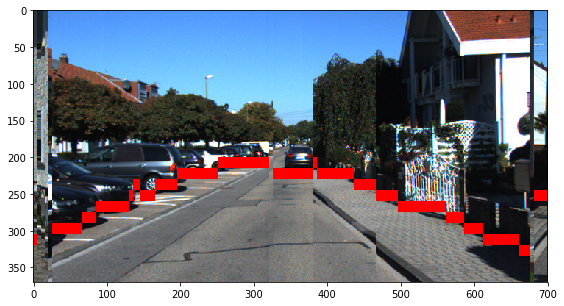

In [128]:
#plotting GT:
some_images_for_plt = some_images[:]/255.0
img = np.ones([370, 1, 3])
for im in range(some_images_cls[:].shape[0]):
    img0 = plot_im(some_images_for_plt[im,:,:,:], some_images_cls[im])
    img=np.concatenate([img,img0],axis=1)
imgplot = plt.imshow(img[:,1250:1950,:])
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


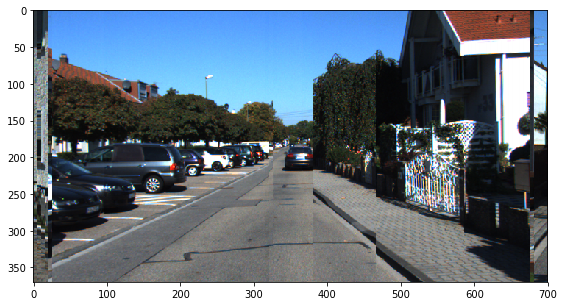

In [130]:
#plot without mark
some_images_for_plt = some_images[:]/255.0
img = np.ones([370, 1, 3])
for im in range(some_images_cls[:].shape[0]):
    img0 = plot_im(some_images_for_plt[im,:,:,:], 16)
    img=np.concatenate([img,img0],axis=1)
imgplot = plt.imshow(img[:,1250:1950,:])
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [131]:
np.histogram(cls_pred_2, bins= [x for x in range(0, 17, 1)])


(array([ 0,  0,  0, 14, 47, 73, 62, 78, 26, 53, 92, 43, 12,  0,  0,  0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]))

In [133]:
np.histogram(some_images_cls, bins= [x for x in range(0, 17, 1)])


(array([ 0,  0,  0,  9, 41, 72, 45, 86, 61, 50, 76, 42, 11,  0,  0,  7]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]))

In [55]:
#extract ground truth data
dataset = tf.data.TFRecordDataset(filenames=path_tfrecords_val_lst)
dataset = dataset.map(parse)
iterator = dataset.make_one_shot_iterator()
images_batch, labels_batch = iterator.get_next()
x = {'image': images_batch}
y = labels_batch
GTlabels=[]
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    for i in range(len(path_tfrecords_val_lst)):
        sess.run(init_op)
        GTlabels.append(sess.run(y))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [62]:
GTlabels = GTlabels[:127104]
len(GTlabels)

127104

In [63]:
df = pd.DataFrame(GTlabels, columns=['GT'])

In [64]:
pd.DataFrame.to_csv(df,'VAL_GT_v1_47.csv')

In [60]:
predictions = model.predict(input_fn=val_input_fn)

In [61]:
cls_pred = list(predictions)
len(cls_pred)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpts_02_06_mobilenetV1_47bins_swap_5e_minus4_fixed/model.ckpt-43001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


127104

In [69]:
cls_pred[900:950]

[16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16]

In [55]:
cls_pred_2=np.argmax(cls_pred, axis=1)

In [56]:
len(cls_pred_2)

117888

In [46]:
len(GTlabels)

117915

In [57]:
df2=pd.DataFrame(cls_pred_2, columns=['preds'])

In [59]:
pd.DataFrame.to_csv(df2,'PREDS.csv')